In [13]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

In [14]:
# Parameters
rseed = 2417
np.random.seed(rseed)  # Set the random seed

# Reproduction and death rates (per hour)
r1 = 0.51  # Rate for first population
r2 = 0.44  # Rate for second population
d1 = 0.0021  # Death rate for first population
d2 = 0.015   # Death rate for second population

# Nutrient consumption and release factors
alphaA = 3.1  # Reproduction nutrient consumption (fmole per cell)
alphaL = 5.4  # Reproduction nutrient consumption (fmole per cell)
gammaA = 0.26  # Hyp release rate (fmole per cell per hour)

# Nutrient levels and rates
HgL = 1e6 * np.array([0, 0.58, 0.65, 0.73, 0.80, 1.07, 1000])  # Hyp levels (fmole/ml)
gammaLH = np.array([0.52, 0.83, 0.78, 0.53, 0.38, 0.08, 0.08])  # Lys release rate (fmole/cell/hr)
nL = 3.2  # Moser's power for Lys
nA = 1.5  # Moser's power for Hyp

# Monod constants
KA = 1.3e6  # Hyp (fmole/ml)
KL = 2.1e6  # Lys (fmole/ml)

# Maximum uptake rates
vmL = alphaL * r1  # Lys (fmole/hour)
vmA = alphaA * r2  # Hyp (fmole/hour)

# Michaelis-Menten constants
KmmL = KL  # Lys
KmmA = KA  # Hyp

# Diffusion constants
D0 = 360  # Agarose/agar (microns²/s)
D1 = 20   # Cells (microns²/s)

# Length scale and domain definitions
c = 5       # Grid size for cells (microns)
SC = 3      # Ratio of diffusion to cell grids
SD = 4      # Ratio of diffusion grid (agar to cells)
g = SC * c  # Grid size for diffusion in cells

# Display translated initialization
parameters = {
    "Reproduction Rates": (r1, r2),
    "Death Rates": (d1, d2),
    "Nutrient Consumption": {"alphaA": alphaA, "alphaL": alphaL},
    "Diffusion Constants": {"D0": D0, "D1": D1},
    "Grid Sizes": {"Cell Grid": c, "Diffusion Grid": g},
}

In [15]:
# Define the solution domain based on the parameters
cell_grid_size = c
diffusion_grid_size = g

# Define grid dimensions (example values for demonstration; MATLAB script likely specifies these later)
domain_size_cells = (50, 50, 50)  # Number of cells in x, y, z directions
domain_size_diffusion = tuple(SC * np.array(domain_size_cells))  # Diffusion grid size scales with cells

# Initialize cell domain and diffusion grid
cell_domain = np.zeros(domain_size_cells, dtype=int)  # Integer grid to track cell states (e.g., alive, dead)
diffusion_grid = np.zeros(domain_size_diffusion, dtype=float)  # Float grid for nutrient concentrations

# Initialize random placement of cells as a starting condition (example)
num_initial_cells = 10
initial_positions = np.random.randint(0, min(domain_size_cells), size=(num_initial_cells, 3))
for pos in initial_positions:
    cell_domain[tuple(pos)] = 1  # Mark cells as alive

# Display example initializations
initialization_summary = {
    "Cell Domain Shape": cell_domain.shape,
    "Diffusion Grid Shape": diffusion_grid.shape,
    "Initial Live Cell Positions": initial_positions.tolist(),
}


In [16]:

# Define a 3D kernel for diffusion
diffusion_kernel = np.array([
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
    [[0, 1, 0], [1, -6, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 1, 0], [0, 0, 0]],
])

# Update diffusion grid (simplified for demonstration)
def update_diffusion(diffusion_grid, D, dt):
    return diffusion_grid + D * convolve(diffusion_grid, diffusion_kernel, mode='constant') * dt

# Example update
D = D0  # Diffusion constant
dt = 0.1  # Time step
diffusion_grid = update_diffusion(diffusion_grid, D, dt)


In [17]:
def update_cells(cell_domain, diffusion_grid, reproduction_rate, death_rate):
    new_cell_domain = cell_domain.copy()
    for x in range(cell_domain.shape[0]):
        for y in range(cell_domain.shape[1]):
            for z in range(cell_domain.shape[2]):
                if cell_domain[x, y, z] == 1:  # Cell alive
                    # Simple nutrient-based growth condition
                    nutrient = diffusion_grid[x, y, z]
                    if nutrient > 1.0:  # Example threshold
                        # Reproduce to a neighboring cell
                        neighbors = [
                            (x + dx, y + dy, z + dz)
                            for dx, dy, dz in [(-1, 0, 0), (1, 0, 0), (0, -1, 0), (0, 1, 0), (0, 0, -1), (0, 0, 1)]
                            if 0 <= x + dx < cell_domain.shape[0]
                            and 0 <= y + dy < cell_domain.shape[1]
                            and 0 <= z + dz < cell_domain.shape[2]
                        ]
                        for nx, ny, nz in neighbors:
                            if new_cell_domain[nx, ny, nz] == 0:  # Empty neighbor
                                new_cell_domain[nx, ny, nz] = 1
                                break
                elif cell_domain[x, y, z] == 0:  # Dead space
                    if np.random.rand() < death_rate:  # Example death probability
                        new_cell_domain[x, y, z] = -1  # Mark as dead
    return new_cell_domain


In [18]:
# Simulation parameters
timesteps = 100
for t in range(timesteps):
    # Update diffusion
    diffusion_grid = update_diffusion(diffusion_grid, D0, dt)
    
    # Update cells
    cell_domain = update_cells(cell_domain, diffusion_grid, r1, d1)


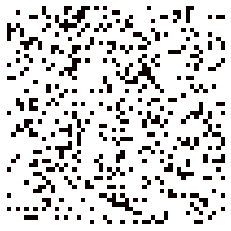

In [20]:
plt.imshow(cell_domain[:,:,0],cmap = 'hot')
plt.gca().axis('off')
#plt.title('CoSMO spatial distribution t=%s hours'%time[0],c='k')
#plt.figure(figsize=(20,20))
plt.show()